# B3 Add Intra Cluster Light onto cluster injections


In this notebook we apply the intra cluster light onto images of synthetic galaxy cluster images


## Objectives

    1 Learn to render intra cluster light as a synthetic image
    
    2 apply intra cluster light to the rendered images


## Setup

This notebook relies on the:

    * synthetic package & dependencies
    
    * DC2 cutotut data files on disk
    
    * curated galaxy cluster member catalog (A4 notebook)
    
    * cluster injection and rendering (B2 notebook)
    


## Output

    * fits image in g, r, i band with clusters and ICL injected
    
    * color composite image for visualization with cluster and ICL injected
 
    
The output files are placed in the `./data/` folder


## Contact

In case of questions, contact me at t.varga@physik.lmu.de

In [4]:
import fitsio as fio
import numpy as np
import pandas as pd
import pickle as pickle
import copy
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.cosmology as cosmology

import images # package from erin sheldon

import synthetic.tools as tools
import synthetic.render.frame as frame
import synthetic.render.render as render
import synthetic.render.icl as icl


pixel_scale = 0.2

*** Important *** set the `nprocess` value to the amount of CPU cores you are willing or allowed to use for this notebook

please consider your local server, e.g. don't run heavy calculations on public login nodes

In [5]:
nprocess = 4

In [6]:
# output path for mock image, be sure to place it into 
out_path = "data/"

# Prepare the DC2 data

This is largely identical to the B2 tutorial

In [7]:
table_path = './data/refdata/curated_table.h5'
table = pd.read_hdf(table_path, key="data")

ra_cen = 50.64516228577292
dec_cen = -40.228830895890404

mock_catalog_path = './data/refdata/curated_mock_catalog.h5'
mock_catalog = pd.read_hdf(mock_catalog_path, key="data")

# Create a shear profile

For illustration purposes, we are going to use an isothermal (power law) shear profile

In case you have other preferences, the below section is where you must modify the line-of-sight catalog

You can add magnification, or other shear profiles as your preferences dictate

In [8]:
cosmo = cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

In [9]:
image_offset=(2499.5, 2499.5)

xra = (mock_catalog['X'] - image_offset[0]) * pixel_scale / 60 # arcmin
ydec = (mock_catalog['Y'] - image_offset[1]) * pixel_scale / 60 # arcmin
dists = np.sqrt(xra**2 + ydec**2)

shears = np.sqrt(1 / dists  / 400) # just for illustration purposes
shears[shears > 0.8] = 0.8 # galsim cannot render very large shears properly

phis =  np.arctan2(ydec, xra)
es1 = (-1. * shears * np.cos(2 * phis))
es2 = (-1. * shears * np.sin(2 * phis))


e1 = mock_catalog['G1']
e2 = mock_catalog['G2']
vals1 = e1 + es1 - e1 * es1 - e2 * es2 # Calculate the sheared galaxy shape
vals2 = e2 + es2 - es1 * e2 + es2 * e1

tmp = np.sqrt(vals1**2. + vals2**2.)
ii = tmp > 0.9 # galsim cannot render very large shears properly, we must reduce the 
divs = 1. / (0.1 + tmp[ii])  
vals1[ii] *= divs
vals2[ii] *= divs

# Add shear only to galaxies, which are at z > 0.4,
# this is a super simple approximation, intended to showcase the functionality
jj = table['redshift_true'] > 0.4

mock_catalog.loc[jj, "G1"] = vals1[jj]
mock_catalog.loc[jj, "G2"] = vals2[jj]

# Render cluster injection

For this example, we are going to use a curated galaxy cluster member catalog

In [11]:
mock_cluster_path = './data/refdata/curated_cluster_model_v01-z0l0_15000_001.h5'
mock_cluster = pd.read_hdf(mock_cluster_path, key="data")

For this example, this is saved in the same database format (exact same columns) as the DC2 catalog which we used above, so we can simply concatenate them in pandas

In [12]:
mock_all = pd.concat((mock_cluster, mock_catalog))

In [13]:
# These are the approcimate noise levels we are going to use for mock images in this notebook
# g, r, i, z bands
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3

# This is the file name root, appended by bands
# we render only g, r, i as those already make a nice color image
file_name_tag = 'test_cluster_canvas_dc2_' #

for i, band in enumerate(("g", "r", "i")):
    name = out_path + file_name_tag + band
    print(name)
    fr = frame.Frame(mock_all.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
    fr.render(nprocess=nprocess) 

data/test_cluster_canvas_dc2_g
starting postage stamp calculations in 1 processes
data/test_cluster_canvas_dc2_r
starting postage stamp calculations in 1 processes
data/test_cluster_canvas_dc2_i
starting postage stamp calculations in 1 processes


# Create intra-cluster-light image

We are creating the ICL as a separate 2D array, for each pixel of the observation canvas. So that it can be manipulated as an image, added directly to the rendered galaxy catalogs. 

This way an arbitrary light profile can be added. In the following we are going to use the approach and codebase derived from Varga et al 2021, based on the parametrization of Gruen et al 2019, using the intra cluster light measurements of Zhang et al 2019.

In this approach, a doughnut shaped pseudo ICL model is calculated, which is the real ICL light profile from which the core Elliptical galaxy is subtracted out, so that the sum of the two components will agree with the observed light distribution.

We should note that the ICL can have an ellipticity in this model, for now simply taken as the orientation of the BCG.

***Right now we are going to place an intra cluster light profile centered around the center of the canvas!***

In [14]:
galpath = "./data/refdata/ICL/evolving_red_gal.dat"
mstarpath = "./data/refdata/ICL/mstar_des_i03.fit"
jk_profile_root = "./data/refdata/ICL/jacknife_profiles_0.15_rand_back_subtracted_corZ_faintgalsub/jacknife_profile_"

bcg = {
    "size": 32.,
    "g1": -0.1356766444194723,
    "g2":0.0345231539560347,
    "imag": 17.76, # i band magnitude
    "color_gr": 1.36,
    "color_ri": 0.54,
    "color_iz": 0.32,
}
mass = 10**14.45 # in solar masses
z = 0.3 # cluster redshift


In [15]:
di = icl.DrawICL(mass, z, bcg, galpath, mstarpath, jk_profile_root)
di.get_icl()
ims_icl = [di.flux_g, di.flux_r, di.flux_i, di.flux_z]

/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/render/icl.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((arr - pos) * k))


then we load the pre icl images:

In [16]:
ims_all = []
for i, band in enumerate(("g", "r", "i")):
    name = out_path + 'test_cluster_canvas_dc2_' + band + ".fits"
    tmp = fio.read(name)
    print(name)
    ims_all.append(tmp)

data/test_cluster_canvas_dc2_g.fits
data/test_cluster_canvas_dc2_r.fits
data/test_cluster_canvas_dc2_i.fits


So that we can simply add the two components together

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8680741786956787


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8681307435035706


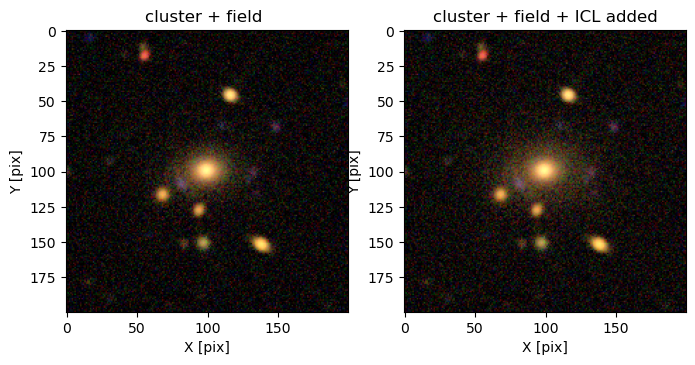

In [17]:
fig, axarr = plt.subplots(ncols=2, figsize=(8, 4))

ax = axarr[0]
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2] + pad,
                                ims_all[1] + pad,
                                ims_all[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2400:2600, 2400:2600] * 2, origin='upper')

ax.set_title("cluster + field ")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")

ax = axarr[1]
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2] + ims_icl[2] + pad,
                                ims_all[1] + ims_icl[1] + pad,
                                ims_all[0] + ims_icl[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2400:2600, 2400:2600] * 2, origin='upper')

ax.set_title("cluster + field + ICL added")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")

fig.savefig("./data/dc2_hp_icl_panel.png", bbox_inches='tight')